In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib
from scipy.linalg import sqrtm, logm, expm
from utils import random_psd, karcher_mean
from geometric_optimizers import RGD_optimizer, RAGD_optimizer, RAGDsDR_optimizer, Riemann_coupling
import matplotlib.pyplot as plt
from pymanopt.manifolds import PositiveDefinite
import torch
import random
import time

%config InlineBackend.figure_format = 'svg'

/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
d = 100 #problem dimension
kappa = 1e2 #condition number of matrices
n = 3 #number of matrices to average

A = np.zeros((d,d,n)) #list of matrices to average 
np.random.seed(99) #
matrix_seeds = np.random.randint(0, 1000, n)
for i in range(n): A[:,:,i] = random_psd(d,kappa,matrix_seeds[i]) #initializing matrices at random
    

M = PositiveDefinite(d)   

def dist(X,Y): return M.dist(X,Y)

def log(X,Y): return M.log(X,Y)

def cost(X):
    c=0
    for i in range(n): c += (1/(2*n))*M.dist(A[:,:,i],X)**2
    return c

def grad(X): #see https://www.math.fsu.edu/~whuang2/pdf/VisitBJU_Slides.pdf
    c=0*X
    for i in range(n): c -= (1/n)*log(X,A[:,:,i])
    return c

def exp(X,U): return M.exp(X,U)
def transp(X,Y,U): return M.transp(X,Y,U)

x_sol = karcher_mean(A, 1e-10)
print('Numerical solution computed')

#initialization
x0 = np.mean(A,axis=2)
N=100
L = 5

0.34645846593691215
0.23705098127340277
0.16843529048469022
0.12306529643476796
0.0918123516797873
0.06958649435061354
0.05338103748091768
0.04133140761067722
0.0322325504106
0.025277722568928126
0.019910341716946514
0.015736446237109576
0.012471054834071063
0.009904209554440279
0.007878836342886341
0.006275918576660999
0.005004323231130614
0.0039936639856020155
0.0031891945048468907
0.0025480893837620737
0.0020366933651867827
0.0016284591628408125
0.0013023835574622687
0.0010418097034758957
0.0008335023280288161
0.0006669287519929978
0.0005336967692978691
0.00042711313137758634
0.00034183545522962973
0.00027359694981006624
0.00021898819165342177
0.00017528378368411886
0.00014030444684718236
0.00011230716190285258
8.989756688602718e-05
7.196004474855573e-05
5.760189269442301e-05
4.610871387646856e-05
3.690876103858898e-05
2.954442636171009e-05
2.3649439380755575e-05
1.8930626426261e-05
1.5153316707897547e-05
1.2129664523127445e-05
9.709303961038468e-06
7.771869638762881e-06
6.221010497

In [3]:
x0 = np.mean(A,axis=2)
N=100
L = 5
mu = 1

t1, x1, f1 = RGD_optimizer(N,x0,L,cost,grad,exp)
t2, x2, f2, beta2 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,10)
t3, x3, f3 = RAGD_optimizer(N,x0,L,mu,cost,grad,exp,log)
t4, x4, f4, beta4 = RAGDsDR_optimizer(N,x0,L,cost,grad,exp,log,transp,-1)
t5, x5, f5 = Riemann_coupling(N,x0,L,1,cost,grad,exp,log)

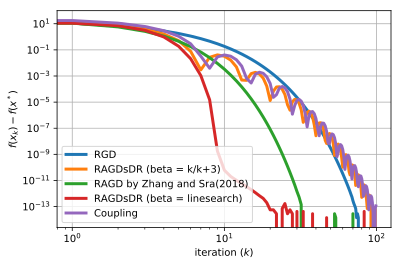

In [4]:
fig, ax = plt.subplots()
ax.loglog(range(N), f1-cost(x_sol),label='RGD',linewidth=3)
ax.loglog(range(N), f4-cost(x_sol),label='RAGDsDR (beta = k/k+3)',linewidth=3)
ax.loglog(range(N), f3-cost(x_sol),label='RAGD by Zhang and Sra(2018)',linewidth=3)
ax.loglog(range(N), f2-cost(x_sol),label='RAGDsDR (beta = linesearch)',linewidth=3)
ax.loglog(range(N), f5-cost(x_sol),label='Coupling',linewidth=3)

#ax.loglog(range(N), 10*np.divide(1,range(N)),'--',label='$O(1/k)$',color='black')
ax.set(xlabel='iteration $(k)$', ylabel='$f(x_k)-f(x^*)$')

ax.grid()
ax.legend()
#ax.set_ylim(bottom=1e-15)
plt.show()
#fig.savefig('result.eps', format='eps', dpi=1000)

In [5]:
beta2

array([0.79526826, 0.61611461, 0.00310562, 0.00310562, 0.00310562,
       0.00310562, 0.00310562, 0.00310562, 0.00310562, 0.28174607,
       0.74072641, 0.88662444, 0.94929691, 0.95432191, 0.96747752,
       0.98876376, 0.98876376, 0.98995   , 0.98995   , 0.99689438,
       0.98876376, 0.99689438, 0.98876376, 0.98995   , 0.98373876,
       0.99689438, 0.98995   , 0.99689438, 0.99689438, 0.98373876,
       0.99689438, 0.98373876, 0.98876376, 0.98876376, 0.99689438,
       0.96747752, 0.85912696, 0.95432191, 0.94235253, 0.83089635,
       0.82157949, 0.38388539, 0.85218259, 0.78832388, 0.47021658,
       0.9210663 , 0.82971011, 0.76703764, 0.61611461, 0.50465843,
       0.58669776, 0.7658514 , 0.61611461, 0.39320225, 0.77398202,
       0.91174943, 0.92801067, 0.89978006, 0.85218259, 0.48218595,
       0.7964545 , 0.85218259, 0.91174943, 0.90480506, 0.9210663 ,
       0.6412396 , 0.83089635, 0.54412528, 0.84286573, 0.82157949,
       0.62927023, 0.94235253, 0.75269578, 0.91174943, 0.91174

In [6]:
x_sol

array([[ 0.1565098 ,  0.00340744, -0.00502278, ..., -0.00904179,
         0.00422034, -0.00061355],
       [ 0.00340744,  0.17286075, -0.01397327, ..., -0.02056019,
        -0.00348709, -0.01035961],
       [-0.00502278, -0.01397327,  0.16266233, ...,  0.00584757,
        -0.00061204, -0.00856951],
       ...,
       [-0.00904179, -0.02056019,  0.00584757, ...,  0.1718519 ,
         0.00287766, -0.00471364],
       [ 0.00422034, -0.00348709, -0.00061204, ...,  0.00287766,
         0.1493701 ,  0.0139278 ],
       [-0.00061355, -0.01035961, -0.00856951, ..., -0.00471364,
         0.0139278 ,  0.1664039 ]])

In [7]:
x0

array([[ 0.26247046,  0.00845759, -0.00185513, ..., -0.01414576,
         0.01198753, -0.00543764],
       [ 0.00845759,  0.26420075, -0.01905295, ..., -0.02523528,
        -0.00027671, -0.02715959],
       [-0.00185513, -0.01905295,  0.26284083, ...,  0.00585157,
        -0.00137547, -0.00642142],
       ...,
       [-0.01414576, -0.02523528,  0.00585157, ...,  0.27324306,
         0.00953405, -0.00886844],
       [ 0.01198753, -0.00027671, -0.00137547, ...,  0.00953405,
         0.24560666,  0.02221673],
       [-0.00543764, -0.02715959, -0.00642142, ..., -0.00886844,
         0.02221673,  0.2652977 ]])

In [8]:
max_eig

NameError: name 'max_eig' is not defined